This is a full walkthrough that I can write up in Jupyter Notebooks, publish to GitHub, and link on my profile/resume.

In [107]:
# General imports
import pandas as pd
import numpy as np
import random

# Machine Learning Process
Hands-On Machine Learning (HOML) has a great machine learning checklist that we can use to help guide any project. Here are the high-level steps:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it. (Explore many different models and short-list the best ones.)
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Each of these steps has many sub-steps to help us understand and solve problems using machine learning. (I won't reproduce them here, but they're in Appendix B of the book.)

# Step 1—Look at the big picture
First, we need a problem to solve. Our problem comes from a hypothetical real estate company that we work for.

## Problem Definition
In this scenario, we've been asked to build a model of housing prices in California using census data. Our goal is to predict the mean housing price in any district.

*How will this model be used?*

The output of our model (the housing price prediction) is going to be fed into another downstream machine learning model which will be used to determine if we should invest in a given district or not.

*Why are we spending the time to develop the model?*

We have mean housing prices for many districts, but there are quite a few where we don't. Currently, a team of experts looks at all of the available data for a district and manually estimates the mean housing price. This takes a lot of time, and estimates can frequently be off by more then 20%. Having a model make these predictions could save the company time and money, and could potentially make more accurate predictions.

*Inputs and outputs*

The **inputs** of our model are going to be variables related to the district: median income, district population, etc. The **output** of our model is going to be a single number, our prediction of the median housing price in the district. The data we have to construct our model contains information about districts where we know the median housing price—in other words, it has both predictor variables and labels.

*Specifying the type of problem and type of solution*

Thus, we have a **supervised regression** problem, and more specifically a **univariate multiple regression** problem since we're only predicting a single value (target) and we have multiple inputs (predictors/regressors). We don't need to worry about creating a model that changes continuously with streaming data, and our training data can fit in memory, so we can rely on simple batch learning to train our model.

*Performance metric*

The Root Mean Square Error (RMSE) is the generally preferred performance metric for regression problems of this sort, so we'll choose that.

# Step 2—Get the data
Now that we've framed the problem, we need to get the data. In our case, we'll be using the California Housing Prices dataset from StatLib: http://lib.stat.cmu.edu/datasets/ (houses.zip).

## Setting up the environment
But first, let's talk about our development environment. Usually, we would want to set up an isolated development environment using virtualenv or conda. Since we're not going to be using any special libraries other than what comes pre-installed in the Anaconda distribution, we'll skip this step for now.

Here's how we would create the virtual conda environment if needed:

```
$ # Create a new virtual conda environment, then install our needed libraries.
$ conda create -n housingenv
$ conda install -n myenv jupyter matplotlib numpy pandas scipy scikit-learn seaborn

$ # Activate our new conda environment.
$ activate housingenv

$ # Test imports for all of our installed libraries to make sure the environment is set up correctly.
$ python -c "import jupyter, matplotlib, numpy, pandas, scipy, sklearn, seaborn"
```

## Getting the data
We'll use helper download and load functions from HOML. Having these as functions is useful because it allows easier automation and replication of the entire pipeline.

Data loading helper functions are stored in a file named `data_loading.py`.

In [106]:
from data_loading import fetch_housing_data, load_housing_data

# download the data as a .tgz and unzip it
fetch_housing_data()

# load the data as a pandas DataFrame
housing = load_housing_data()

In [3]:
# look at the first five rows of data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Step 3—Discover and visualize the data
In this step, we'll do three specific things:

1. First, we'll look at very high-level summary statistics of the data.
2. Then, we'll create our **test dataset**—a 20% subset of the data that we won't look at or use in training our model. This data will be used after creating the model to help assess how well our model will generalize to new data.
3. Then, we'll dive into our training data more deeply to understand relationships between variables and start getting a sense for what information is most correlated with our target (median housing price).

## High-level summary statistics
First, we'll use the `.info()` method to look at the data types and non-null counts of our fields.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


It looks like we have 10 fields (columns/variables) total: 9 input variables (e.g. longitude, median_income) and 1 output variable (median_house_value). There are 20,640 records/rows total, and all variables have complete (non-null) data except for `total_bedrooms` which is missing 207 records. All variables are numeric except for `ocean_proximity`, which is a string (although the `object` data type could hold other objects as well).

In [14]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Next, we'll use `.describe()` method to get summary statistics for the numeric fields.

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see that our variables have very different scales, which means some algorithms won't perform as well. We'll want to standardize our columns during the data processing phase.

Finally, let's plot histograms of our variables.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

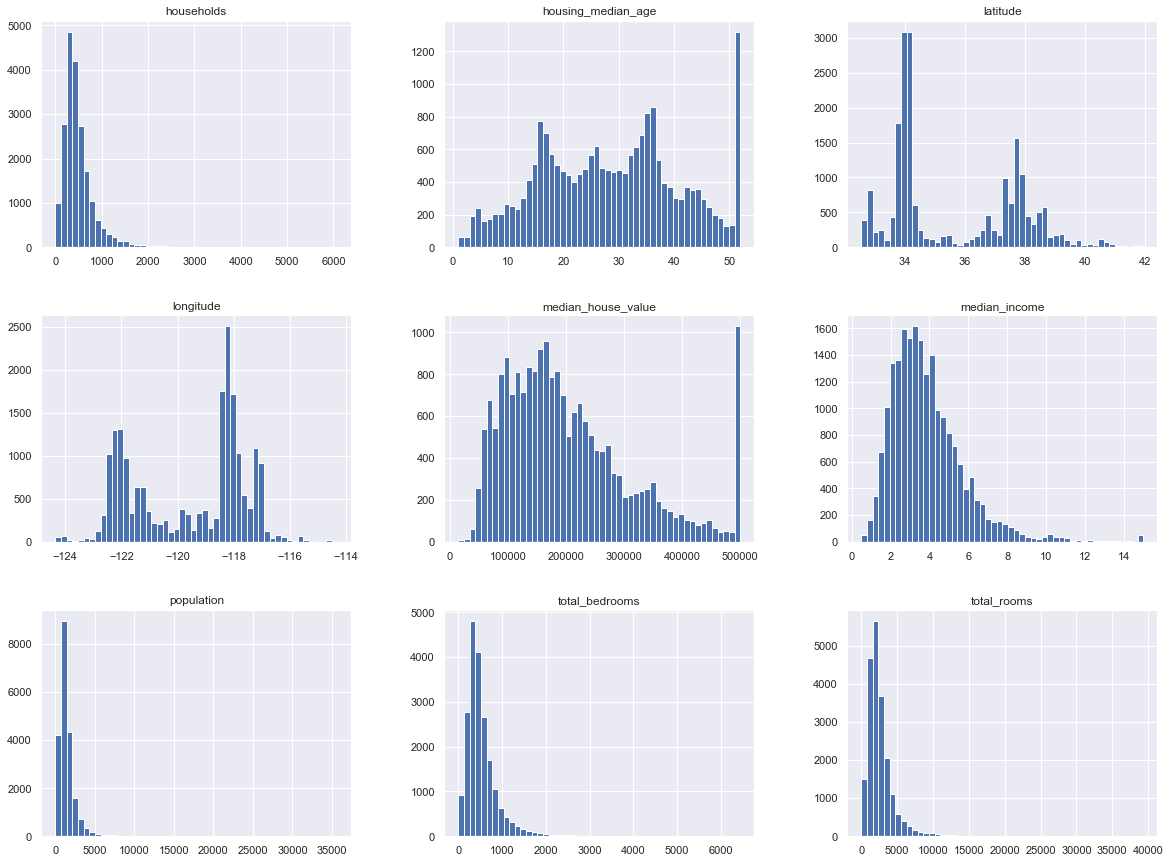

In [20]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

From these histograms, we can see that our variables have different distributions. Many variables have long tails to the right, and housing age and value have large spikes at the maximum value of their ranges, which probably implies that the data was capped (i.e. that everything above a certain value was listed as having the maximum allowed value, such as 55 and 60 and 80 all getting listed as 50). We'll need to address both of these qualities of the data in order to make more accurate predictions.

## Create a test set
Before we continue looking at the data, we need to set aside a "test set" which won't be looked at until we evaluate our final model. Although we could use a more sophisticated data splitting method (such as stratified sampling), we'll just use random sampling to split off 20% of the data.

In [21]:
from sklearn.model_selection import train_test_split

In [24]:
# we'll set the random state so that we can reproduce the split later
training_data, test_data = train_test_split(housing, test_size=0.2, random_state=42)

In [68]:
print(training_data.shape, "--", len(training_data)/len(housing))
print(test_data.shape, "--", len(test_data)/len(housing))

(16512, 10) -- 0.8
(4128, 10) -- 0.2


Now, we'll create a copy of our training data and assign it back to `housing`.

In [83]:
housing = training_data.copy()

## Exploratory data analysis
Now that we've created our test set, we're ready to dive deeper into exploring our training data.

### Geographic data
First, since we have latitude and longitude, let's visualize that.

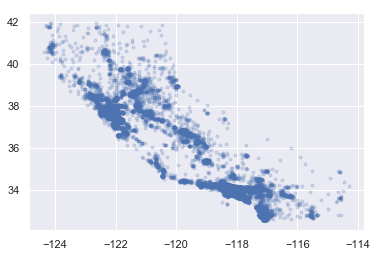

In [73]:
_ = plt.plot(
    training_data["longitude"],
    training_data["latitude"],
    marker='.',
    linestyle='none',
    alpha=0.2)

Looks like California! Since we set the transparency lower, we can see the density of data points.

Let's tweak our plot a bit to show more information. We'll color the data points by our target (median house value) and we'll size the data points by district population. We'll also resize the plot and add some legends.

Note how in the previous cell we used `plt.plot()` and in this cell we're using `housing.plot()`. Both of these methods use matplotlib on the backend—pandas just gives us a helpful `plot` method for DataFrames.

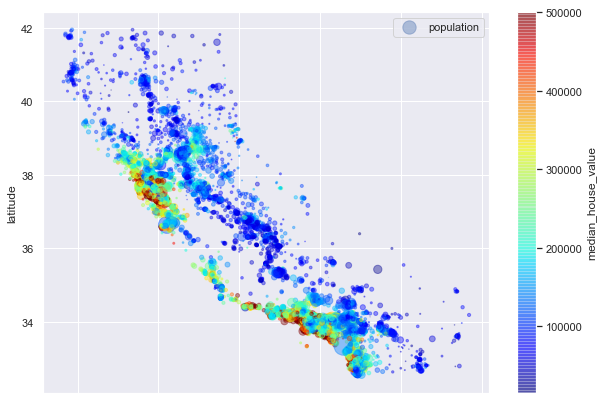

In [74]:
# Assigning the plot return to _ is just a way of preventing Python from printing
# the plot object before the plot by assigning it to a throwaway variable.
# These settings are from HOML.
_ = housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing["population"]/100,
    label="population",
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)

We can see that the population is concentrated in two main north-south bands: one that runs along the coast, and the other that runs down the middle of the state. The housing prices are much higher along the coast, though, especially in the Bay Area and the Los Angelese to San Diego corridor. House prices are also a bit higher around Sacramento.

### How correlated are our variables?
Now we can spend a bit of time looking for correlations between our input variables, and between each input variable and our target variable.

First, we'll show how seaborn has a handy function that allows us to see scatterplots of each variable against each other variable. With 9 numeric variables, this is quite a lot of graphs—but let's look at them all anyway!

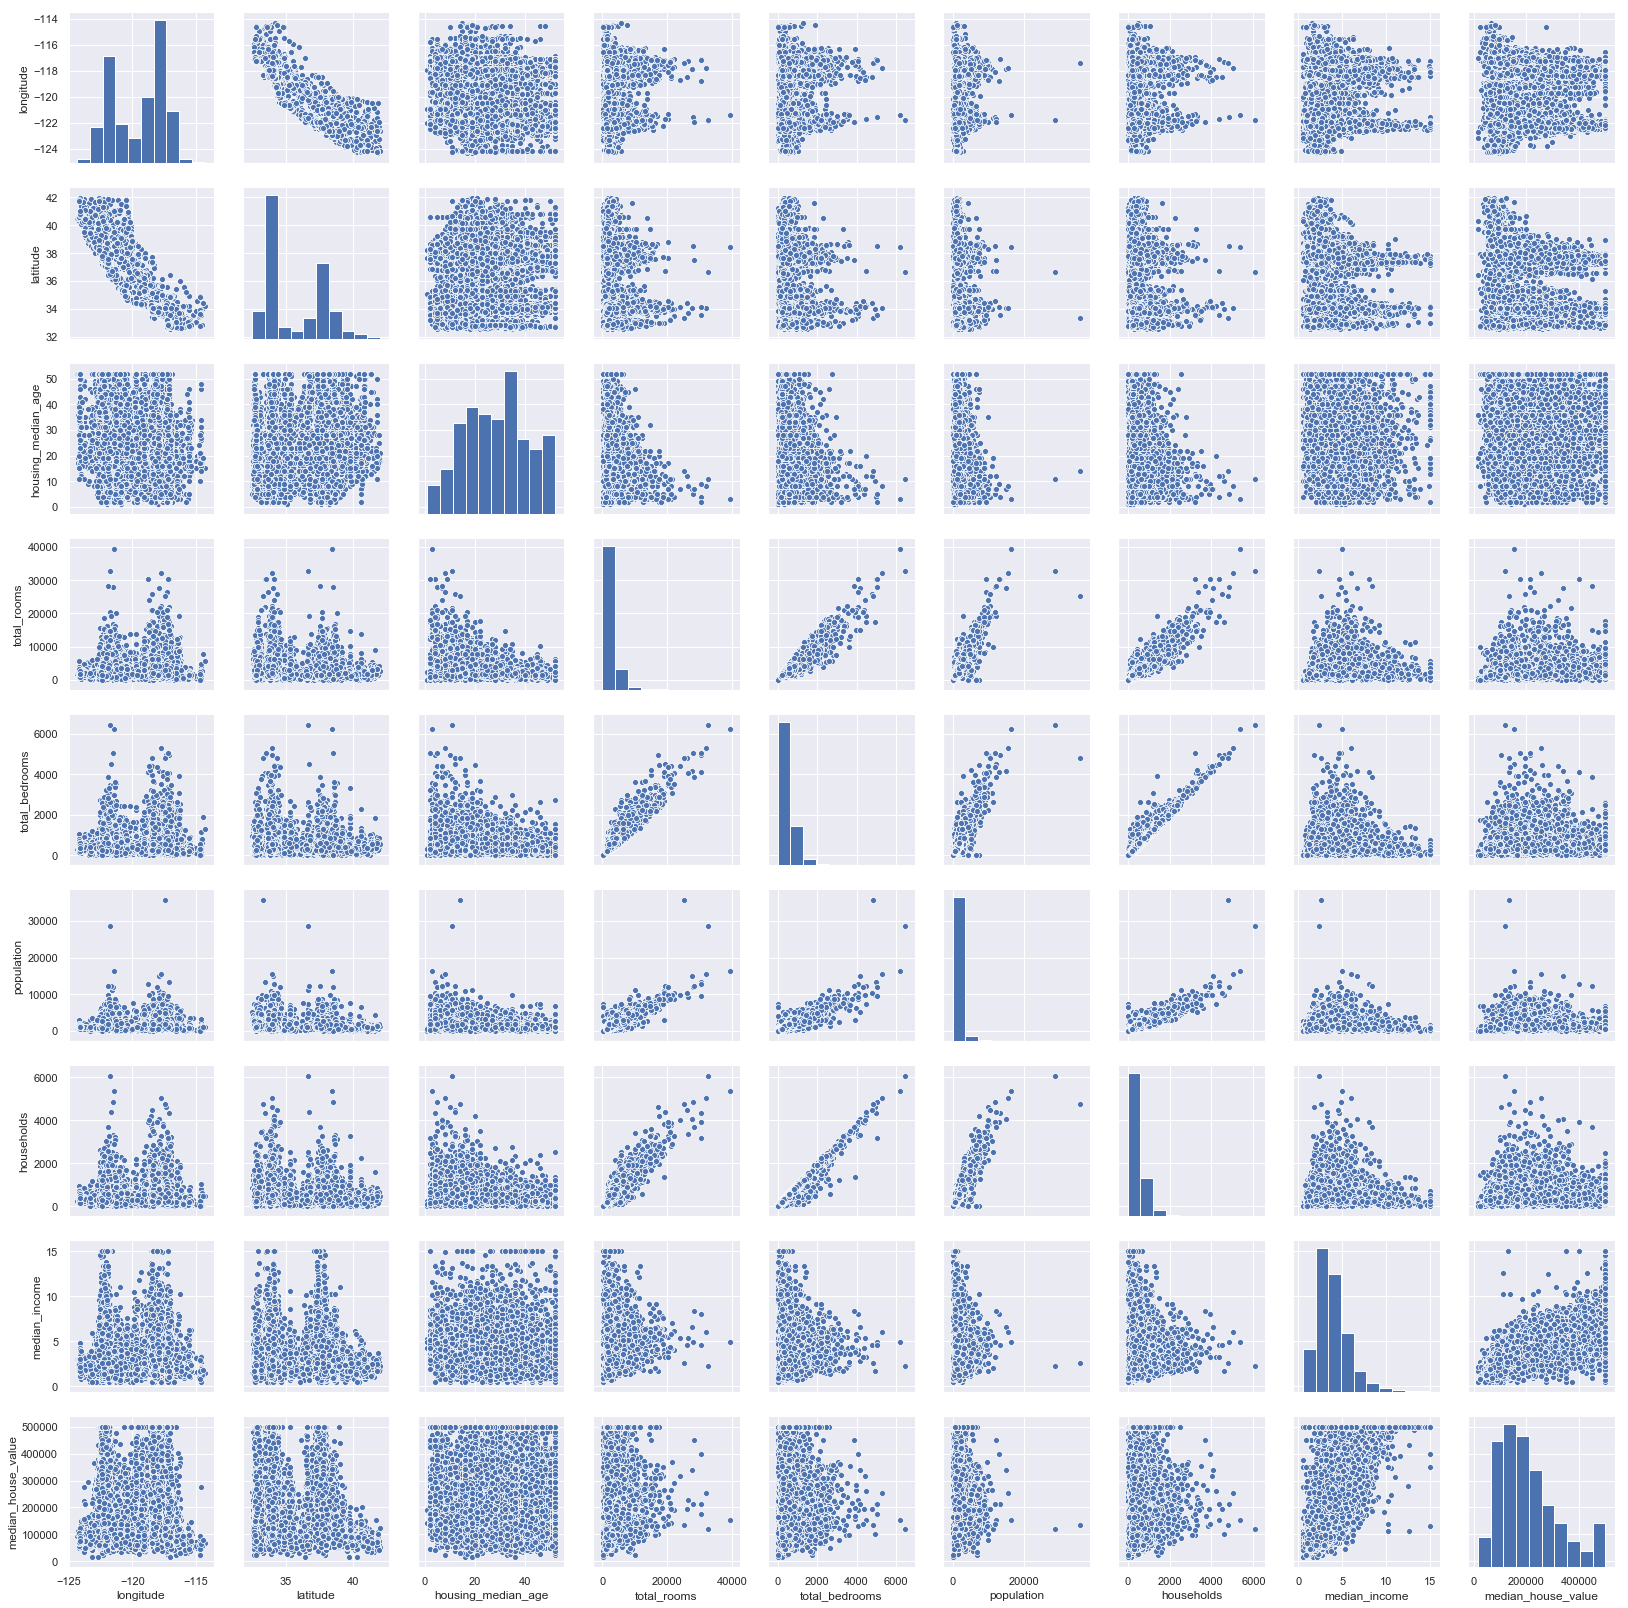

In [75]:
_ = sns.pairplot(housing)

We see that some variables are very correlated, such as `total_bedrooms` and `households`, or `population` and `total_rooms`. This makes sense though and isn't actually very helpful, because it seems fairly obvious that the number of rooms in a district will go up as the number of houses goes up, or that houses also increase with population.

It's hard to tell which things are correlated with our target variable, `median_house_value`. Let's look at a numeric summary of variable correlation.

In [76]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924485,-0.101818,0.038676,0.063064,0.094276,0.049306,-0.017040,-0.046349
latitude,-0.924485,1.000000,0.005296,-0.029224,-0.059998,-0.102499,-0.064061,-0.076571,-0.142983
housing_median_age,-0.101818,0.005296,1.000000,-0.360922,-0.320624,-0.292283,-0.302796,-0.121711,0.103706
total_rooms,0.038676,-0.029224,-0.360922,1.000000,0.930489,0.857936,0.920482,0.198268,0.133989
total_bedrooms,0.063064,-0.059998,-0.320624,0.930489,1.000000,0.878932,0.980255,-0.009141,0.047980
population,0.094276,-0.102499,-0.292283,0.857936,0.878932,1.000000,0.907452,0.004122,-0.026032
households,0.049306,-0.064061,-0.302796,0.920482,0.980255,0.907452,1.000000,0.012776,0.063714
median_income,-0.017040,-0.076571,-0.121711,0.198268,-0.009141,0.004122,0.012776,1.000000,0.690647
median_house_value,-0.046349,-0.142983,0.103706,0.133989,0.047980,-0.026032,0.063714,0.690647,1.000000


In [77]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

It looks like `median_income` is actually quite positively correlated with `median_house_value`—it will be a valuable variable in our model. It looks like `total_rooms` and `housing_median_age` are also positively correlated with house value, and latitude is slightly negatively correlated (meaning houses are cheaper to the north).

Let's look at the heatmap of how correlated all variables are with each other, since it can be hard to tell at a glance from the 9x9 DataFrame above.

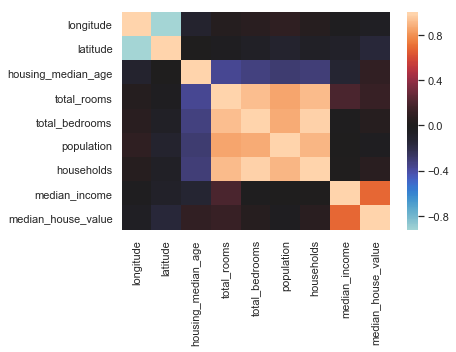

In [78]:
_ = sns.heatmap(housing.corr(), center=0)

We can see again that rooms, houses, population, etc. are very correlated with each other. We also see that income and house value are correlated. Latitude and longitude are strongly negatively correlated, which simply reflects the northwest-to-southeast orientation of the state of California.

Interestingly, we see slightly negative correlations between `housing_median_age` and rooms, bedrooms, population, and households.

### Creating new input variables
A big part of machine learning is feature engineering: transforming existing features (input variables), removing uninformative ones, and creating new ones with the hope that they're more informative.

Let's spend some time creating new features and seeing if any of them are more informative than our existing features. Here are some things we might naturally think to do:

1. Create variables for `rooms_per_household`, `bedrooms_per_room`, and `population_per_household`.
2. Divide each variable by `median_income`.
3. Square each variable.
4. Multiple each variable by each other variable.

In [84]:
# 1 - Create alternate variables for rooms, bedrooms, population.
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [85]:
#2 - Divide variables by median_income.
v_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households']
for v in v_cols:
    housing[v + "_div_income"] = housing[v]/housing["median_income"]

In [86]:
#3 - Square variables
for v in v_cols:
    housing[v + "_squared"] = housing[v]**2

In [87]:
#4 - Multiple variables by each other variable
for i, v in enumerate(v_cols):
    print(i, v)

0 longitude
1 latitude
2 housing_median_age
3 total_rooms
4 total_bedrooms
5 population
6 households


In [91]:
#4 - Multiple variables by each other variable
for i, v in enumerate(v_cols):
    for v2 in v_cols[i+1:]:
        housing[v + "_times_" + v2] = housing[v] * housing[v2]

Now let's look at our correlation matrix again, this time just looking at correlations with the target variable.

In [94]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value                         1.000000
median_income                              0.690647
longitude_div_income                       0.518366
housing_median_age_times_total_rooms       0.264237
rooms_per_household                        0.158485
housing_median_age_times_households        0.153328
housing_median_age_times_total_bedrooms    0.138512
total_rooms                                0.133989
latitude_times_total_rooms                 0.124553
housing_median_age_squared                 0.119610
housing_median_age                         0.103706
longitude_times_latitude                   0.103504
latitude_times_housing_median_age          0.086621
total_rooms_squared                        0.063717
households                                 0.063714
latitude_times_households                  0.054747
total_rooms_times_households               0.049418
total_bedrooms                             0.047980
longitude_squared                          0.046140
total_rooms_

This is really interesting! Here are some of the new variables that appear very correlated (positively or negatively) with our target:

- longitude divided by income
- housing age times total rooms
- rooms per household
- bedrooms per room
- housing age divided by income
- (many others divided by income)

Additionally, we see many that don't appear very correlated with our target. We may want to eliminate these columns further along in the process.

One other thing to be careful of is that we've created many new columns that are highly correlated with other columns. For example, `total_rooms` is now highly correlated with `total_rooms_times_population`, etc. Highly correlated input variables can have a negative effect on some algorithms, so we need to watch out for this.

Now that we've done some more thorough data exploration, let's clean the data and prepare it for training models.

# Step 4—Prepare the data for machine learning algorithms
There are a few things we're going to do here:

1. Separate the input variables (predictors) from the output variable (target), since we probably don't want to do the same transformations to our target that we do for our predictors.
2. Decide what to do with the missing values in `total_bedrooms`.
3. Turn the string field `ocean_proximity` into some kind of numeric field(s) the machine learning algorithms can work with.
4. Scale our features to the same range.
5. Put all of it together into a full data cleaning pipeline.

## Separate input from output variables
Let's go back to our training data (before adding all of the new input variables) and split out the inputs from the output. This is straightforward:

In [171]:
housing = training_data.drop("median_house_value", axis=1)
housing_labels = training_data["median_house_value"].copy()

## Deal with missing / null / NA values
We have 207 missing values in `total_bedrooms` that we need to do something with. ML algorithms often don't work with nulls.

There are three primary options for what we can do:

1. Drop the rows that have missing values.
2. Drop the whole column.
3. Set the missing values to some value (the median, etc.).

We'll go with option #3 and use scikit-learn's `SimpleImputer` class to help us out. Rather than using the imputer on only the variable that *currently* has missing values, we'll use it on the full training data in case we get any future data points that have missing values in other columns. We'll need to exclude `ocean_proximity` for now and deal with it later, since it isn't a numeric variable.

In [98]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [99]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [103]:
imputer.fit(housing_num)
print(imputer.statistics_)
print(imputer.statistics_ == housing_num.median().values)

[-118.51     34.26     29.     2129.      437.     1167.      410.
    3.5458]
[ True  True  True  True  True  True  True  True]


In [108]:
# This returns a numpy array, so we need to put it back into a pandas DataFrame
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [109]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


We can now see that our `total_bedrooms` column doesn't have any nulls. Success!

## Transform categorical / text variables
We only have one categorical variable in this dataset, `ocean_proximity`. Since this isn't an ordinal variable, we'll want to use one-hot encoding.

In [124]:
housing_cat = housing[["ocean_proximity"]].copy()
housing_cat["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [125]:
from sklearn.preprocessing import OneHotEncoder

In [126]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

## Custom transformers
We can write custom transformers to do the variable creation and manipulation that we were doing earlier (e.g. creating `rooms_times_latitude` field and things like that). However, we're not going to write this just yet.

**We'll come back to this later.**

## Feature scaling
We have two primary options here: mix-max scaling (normalization) and standardization. Here are basic descriptions:

- mix-max / normalization: rescale into a range of 0 to 1.
- standardization: subtract mean, divide by standard deviation (0 mean, unit variance).

We'll use the scikit-learn `StandardScaler` class, which employs standardization.

In [128]:
from sklearn.preprocessing import StandardScaler

In [130]:
standard_scaler = StandardScaler()
housing_num_scaled = standard_scaler.fit_transform(housing_tr)
housing_num_scaled = pd.DataFrame(housing_num_scaled, columns=housing_tr.columns)
housing_num_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,1.272587,-1.372811,0.348490,0.222569,0.211228,0.768276,0.322906,-0.326196
1,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843
2,-0.447603,-0.460146,-1.952710,-0.342597,-0.495226,-0.449818,-0.430461,0.144701
3,1.232698,-1.382172,0.586545,-0.561490,-0.409306,-0.007434,-0.380587,-1.017864
4,-0.108551,0.532084,1.142008,-0.119565,-0.256559,-0.485877,-0.314962,-0.171488


In [133]:
housing_num_scaled.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.00,16512.00,16512.00,16512.00,16512.00,16512.00,16512.00,16512.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.38,-1.45,-2.19,-1.21,-1.28,-1.25,-1.31,-1.78
25%,-1.11,-0.80,-0.84,-0.55,-0.58,-0.56,-0.58,-0.69
50%,0.53,-0.65,0.03,-0.24,-0.24,-0.23,-0.24,-0.18
75%,0.78,0.97,0.67,0.24,0.26,0.26,0.28,0.47
max,2.63,2.95,1.86,16.87,14.10,30.13,14.65,5.84


## Use a Pipeline to bring it all together
Since there are a lot of steps that need to happen as we're preparing the data, scikit-learn gives us a very useful `Pipeline` class that we can use to easily string all of the steps together in a more organized fashion.

In [134]:
from sklearn.pipeline import Pipeline

In [138]:
# First, create a pipeline for the numeric variables
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('standard_scaler', StandardScaler()),
])

In [139]:
housing_num_tr = numeric_pipeline.fit_transform(housing_num)

To transform both the numeric and the categorical variables, we can use the `ColumnTransformer` class.

In [140]:
from sklearn.compose import ColumnTransformer

In [174]:
numeric_variables = list(housing.drop("ocean_proximity", axis=1))
categorical_variables = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_variables),
    ('categorical', OneHotEncoder(), categorical_variables),
])

In [175]:
housing_prepared = full_pipeline.fit_transform(housing)

And now we have a numpy ndarray (note: `.fit_transform()` often (always?) returns a numpy ndarray) ready for fitting a model to!

# Step 5—Train some models, create a shortlist of promising ones
Now we finally reach the part that people usually think of as "machine learning"! (Quite a lot of work to get here, eh?)

The goal here is to try a bunch of models using the default (or close to default) settings, and then create a shortlist of promising ones to further optimize. We'll start with basic linear regression and then move to more complex models from there. We'll use cross validation to measure our goodness of fit.

In [198]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [194]:
from collections import OrderedDict

In [199]:
models = OrderedDict()

models["lin_reg"] = LinearRegression()
models["lasso"] = Lasso()
models["elastic net"] = ElasticNet()
models["tree"] = DecisionTreeRegressor()
models["lin_svr"] = LinearSVR()
models["svr"] = SVR()
models["forest"] = RandomForestRegressor()
models["gradient_boosted"] = GradientBoostingRegressor()

for key in models:
    model_name = key
    model = models[key]
    scores = cross_val_score(model, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print(model)
    print("Mean score:", np.mean(rmse_scores))
    print("Score standard deviation:", np.std(rmse_scores))
    print("All scores:", rmse_scores)
    print("---")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Mean score: 68595.39608481781
Score standard deviation: 2496.5245371674655
All scores: [65581.45520649 71711.35784404 68143.02388491 66855.55244479
 69440.38017435 65640.36503235 65861.37192245 69898.33048393
 73117.94692191 69704.17693297]
---


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Mean score: 68595.39225666272
Score standard deviation: 2497.089005197422
All scores: [65581.98820785 71708.54840902 68143.07209791 66855.29542321
 69447.589224   65640.73191381 65855.30906066 69898.03981884
 73118.36211724 69704.98629409]
---
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Mean score: 78270.36300531772
Score standard deviation: 1813.1119884714765
All scores: [76865.93479828 82029.832163   77373.68545851 76580.85627927
 79435.7819237  77526.97893904 75750.79423574 78721.87652041
 78008.0127084  80409.87702683]
---
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
Mean score: 118440.50660539659
Score standard deviation: 2010.8888143754862
All scores: [119308.73310832 121259.58484942 119434.86735096 114403.59816927
 118147.87378539 119610.01077053 115922.99294501 116743.54925586
 119509.68981274 120064.16600647]
---


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean score: 51626.561196259
Score standard deviation: 1710.7113405566108
All scores: [49808.92936185 52742.91171046 50965.77368056 51473.82666423
 53690.01830418 50300.06050501 48300.39879115 53911.85519602
 52149.85290346 52921.98484568]
---
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_it

So with zero modification to the defaults, it looks like our models perform in this order (best to worst by RMSE):

1. Random forest: 51,000
2. Gradient boosting regressor: 55,000
3. Decision tree: 68,000
4. Linear regression: 69,000
5. Lasso: 69,000
6. Elastic net: 78,000
7. SVR: 118,000
8. Linear SVR: 220,000

# Step 6—Fine-tune your model
TBD

# Step 7—Present your solution
TBD

# Step 8—Launch, monitor, and maintain your system
TBD